In [ ]:
## Example code for Agent movement simulation using location graph prepard from locations in Amsterdam.
## The code outlines a basic structure of the movement model. The outputs from this notebook might differ slightly 
## from the ones used in the paper due to changes in LLM model parameters and details. 

In [1]:
# ! pip install langchain --user
# ! pip install openai
# ! pip install python-dotenv
# ! pip install termcolor 
# ! pip install faiss-cpu
# ! pip install tiktoken  --user
# ! pip install transformers --user

In [3]:
from langchain.llms import OpenAI

llm = OpenAI(openai_api_key="YOUR_API_KEY")

In [4]:
from dotenv import load_dotenv

# Load environment variables from the .env file

load_dotenv()

True

In [5]:
import logging

logging.basicConfig(level=logging.ERROR)
from datetime import datetime, timedelta
from typing import List
from termcolor import colored


from langchain.chat_models import ChatOpenAI
from langchain.docstore import InMemoryDocstore
from langchain.embeddings import OpenAIEmbeddings
from langchain.retrievers import TimeWeightedVectorStoreRetriever
from langchain.vectorstores import FAISS
from langchain.tools import BaseTool  ## for custom transformer tool
from langchain.chat_models import ChatOpenAI ## for custom transformer tool
from langchain.chains.conversation.memory import ConversationBufferWindowMemory ## for custom transformer tool

# from image_description.llm_img_agent import scene_summarizer

In [6]:
from langchain.llms import OpenAI

llm = ChatOpenAI(temperature=0.9, model = "gpt-3.5-turbo-16k")  ## The temperature of values less than 0.9 show a more formal text generation, devoid of creativity in answers or observations.

In [8]:
llm.predict("What would be a good company name for a company that makes colorful socks?")

'1. ChromaSock\n2. VibrantVibe\n3. ColorThread\n4. RainbowFootwear\n5. TintedTreads\n6. HueAvenue\n7. ChromaticSocks\n8. SpectrumSoles\n9. PrismaticPeds\n10. TechnicolorToes\n11. TintasticTreads\n12. VividVestments\n13. Kaleidosock\n14. ColorSplashSocks\n15. ChromazoneSocks'

In [10]:
import networkx as nx
import matplotlib.pyplot as plt

# Load the graph from GraphML file
G = nx.read_graphml("real_ams_route.graphml")

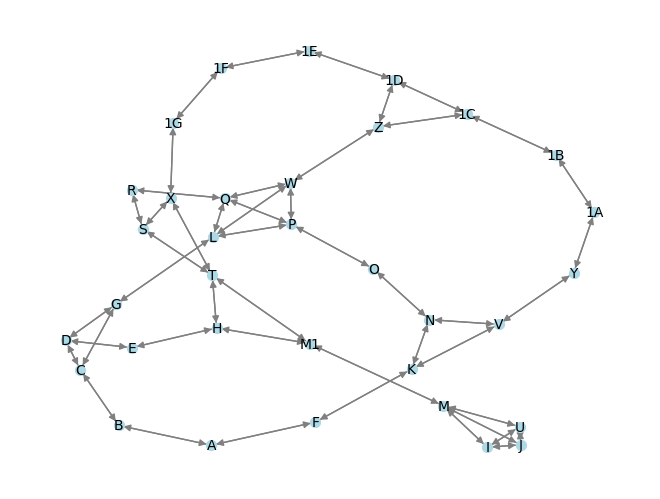

In [11]:
# Draw the graph
nx.draw(G, with_labels=True, node_size=50, node_color='lightblue', font_size=10, font_color='black', edge_color='gray')

# Show the graph
plt.show()

In [12]:
## Testing graph

first_node = 'C'

# Find the neighbors of the first node
neighbors = list(G.neighbors(first_node))
print(neighbors)

# Access edge properties for each neighbor
for neighbor in neighbors:
    edge_properties = G[first_node][neighbor]
    print(f"Edge from {first_node} to {neighbor} has properties: {edge_properties}")

['B', 'D', 'G']
Edge from C to B has properties: {'direction': 'backward'}
Edge from C to D has properties: {'direction': 'forward'}
Edge from C to G has properties: {'direction': 'left'}


In [13]:
## Function to provide new node based on agent's decision to move at certain direction

def move_to_next_node(current_node, direction):
    neighbors = G[current_node]
    for neighbor in neighbors:
        if G[current_node][neighbor]['direction'] == direction:
            return neighbor, G.nodes[neighbor]['stview']
    return None, None


# print(move_to_next_node('D', 'forward'))

In [14]:
## For troubleshooting, when agent is not able to select right direction

# import random

# def move_to_next_node(current_node, direction):
#     neighbors = G[current_node]
    
#     # Check if the specified direction is available
#     valid_neighbors = [neighbor for neighbor in neighbors if G[current_node][neighbor].get('direction') == direction]
    
#     if valid_neighbors:
#         # If there are valid neighbors in the specified direction, randomly choose one
#         selected_neighbor = random.choice(valid_neighbors)
#         return selected_neighbor, G.nodes[selected_neighbor]['stview']
#     else:
#         # If the specified direction is not available, randomly choose any direction
#         if neighbors:
#             selected_neighbor = random.choice(list(neighbors))
#             return selected_neighbor, G.nodes[selected_neighbor]['stview']
#         else:
#             # If no neighbors are available, return None
#             return None, None


In [17]:
from generative_agents import (
    GenerativeAgent,
    GenerativeAgentMemory,
)

In [18]:
import math
import faiss


def relevance_score_fn(score: float) -> float:
    """Return a similarity score on a scale [0, 1]."""
    # This will differ depending on a few things:
    # - the distance / similarity metric used by the VectorStore
    # - the scale of your embeddings (OpenAI's are unit norm. Many others are not!)
    # This function converts the euclidean norm of normalized embeddings
    # (0 is most similar, sqrt(2) most dissimilar)
    # to a similarity function (0 to 1)
    return 1.0 - score / math.sqrt(2)


def create_new_memory_retriever():
    """Create a new vector store retriever unique to the agent."""
    # Define your embedding model
    embeddings_model = OpenAIEmbeddings()
    # Initialize the vectorstore as empty
    embedding_size = 2048
    index = faiss.IndexFlatL2(embedding_size)
    vectorstore = FAISS(
        embeddings_model.embed_query,
        index,
        InMemoryDocstore({}),
        {},
        relevance_score_fn=relevance_score_fn,
    )
    return TimeWeightedVectorStoreRetriever(
        vectorstore=vectorstore, other_score_keys=["importance"], k=15
    )

agents_memory = GenerativeAgentMemory(
    llm=llm,
    memory_retriever=create_new_memory_retriever(),
    verbose=True,  
    reflection_threshold=8,  
)

gen_agent = GenerativeAgent(
    name="Max",
    age=25,
    status="Want to explore the city and find a tree-house around to write a story about it.",  
    memory_retriever=create_new_memory_retriever(),
    llm=llm,
    verbose = True,
    memory=agents_memory,
)

In [19]:
gen_agent.name

'Max'

In [20]:
# The current "Summary" of a character can't be made because the agent hasn't made
# any observations yet.
print(gen_agent.get_summary())



> Entering new  chain...
Prompt after formatting:
How would you summarize Max's core characteristics given the following statements:
Do not embellish.

Summary: 

> Finished chain.
Name: Max (age: 25)
Innate traits: N/A
Backstory and personality: N/A
Max's core characteristics can be described as straightforward and honest.


In [21]:
##visual agent

from image_description.comb_tool import outputs_all_tools
from image_description.cap_tool import outputs_cap_tools
from langchain.llms import OpenAI

from langchain.agents import initialize_agent

from datetime import datetime, timedelta
from typing import List
# from termcolor import colored
from langchain.chat_models import ChatOpenAI
from langchain.tools import BaseTool  ## for custom transformer tool
from langchain.chat_models import ChatOpenAI ## for custom transformer tool
from langchain.chains.conversation.memory import ConversationBufferWindowMemory ## for custom transformer tool

from langchain.llms import OpenAI


tools = []
tools.append(outputs_all_tools())
tools.append(outputs_cap_tools())

print(tools)


conversational_memory = ConversationBufferWindowMemory(
    memory_key='chat_history',
    k=5,
    return_messages=True
)
# initialize agent with tools
visual_agent = initialize_agent(
    agent='chat-conversational-react-description',
    tools=tools,
    llm=llm,
    verbose=False,
    max_iterations=5,
    early_stopping_method='generate',
    memory=conversational_memory,
    handle_parsing_errors=True,
)

sys_msg = """ Assistant is a large language model trained by OpenAI. However, assistant can't see. Therefore to help the assistant see, there are some tools which
the assisitant can use. These tools give the understanding of the overall scene in the urban streets with the help of values. There are two tools, one is used 
when a "decision" is required by the agent, and the other when a "short summary" has to be made. 

When tool for "decision" is being used, It will receive a large amount of text with a lot of details regarding the elements which are present in the scene and the probability score.
It will have 4 types of information, "Segmentation results", "Scene categories", "Scene attributes", and "Object detections".

Point A >> Segmentation gives an idea of what a scene is mainly comprised of like "vegetation", "sky", and "street". Oftentimes the Segmentation results also provide the information regarding the
presence of "traffic light", "person", etc. One of the example of "Segmentation results" is  == 'sky': 'Average', 'building': 'Average', 'vegetation': 'Low', 'traffic sign': 'Present'.
Keep in mind that for Point A, if an element is "Average", no need to consider that, only consider elements with "Low" or "High" and write if it is "Low" or "High".

Point B >> Scene categories provides information on main landmarks identified in the scene, it can be some place like cafetaria, restaurant, promenade, canal, etc. Write all categories you find.

Point C >> Scene attributes shows the lighting of the surroundings and also if horizon can be seen or not. 

Point D >> Object detections provides information on the number of objects present in the scene such as person, cycle, vehicle, etc. 

The main aim of the "decision" tool is to frame 4 sentences from 4 points as mentioned above. First sentence describing Point A and so on.

When tool for "short summary" being used, It will receive the "Scene categories". Frame a basic understanding of the scene from these categories. Do not use values along with the categories.

"""

new_prompt = visual_agent.agent.create_prompt(
    system_message=sys_msg,
    tools=tools
)

visual_agent.agent.llm_chain.prompt = new_prompt
# update the agent tools
visual_agent.tools = tools



c:\Users\isu_v\.conda\envs\langchain\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
c:\Users\isu_v\.conda\envs\langchain\lib\site-packages\transformers\models\segformer\feature_extraction_segformer.py:28: FutureWarning: The class SegformerFeatureExtractor is deprecated and will be removed in version 5 of Transformers. Please use SegformerImageProcessor instead.
  warnings.warn(
c:\Users\isu_v\.conda\envs\langchain\lib\site-packages\transformers\models\segformer\image_processing_segformer.py:99: FutureWarning: The `reduce_labels` parameter is deprecated and will be removed in a future version. Please use `do_reduce_labels` instead.
  warnings.warn(
The `max_size` parameter is deprecated and will be removed in v4.26. Please specify in `size['longest_edge'] instead`.


[outputs_all_tools(name='Seg+Cap+Class', description='use this tool when given the URL of the image and asked about the summary regarding the content of the image.It will return a tuple of string and dictionary of overall caption and detected elements, paired with the corresponding percentage, respectively.', args_schema=None, return_direct=False, verbose=False, callbacks=None, callback_manager=None, tags=None, metadata=None, handle_tool_error=False), outputs_cap_tools(name='Cap', description='use this tool when given the URL of the image and asked about the image caption only.It will return a list of scene categories which will help the agent decide which direction is more prominent in acheiving the goal.', args_schema=None, return_direct=False, verbose=False, callbacks=None, callback_manager=None, tags=None, metadata=None, handle_tool_error=False)]


In [22]:
tools

[outputs_all_tools(name='Seg+Cap+Class', description='use this tool when given the URL of the image and asked about the summary regarding the content of the image.It will return a tuple of string and dictionary of overall caption and detected elements, paired with the corresponding percentage, respectively.', args_schema=None, return_direct=False, verbose=False, callbacks=None, callback_manager=None, tags=None, metadata=None, handle_tool_error=False),
 outputs_cap_tools(name='Cap', description='use this tool when given the URL of the image and asked about the image caption only.It will return a list of scene categories which will help the agent decide which direction is more prominent in acheiving the goal.', args_schema=None, return_direct=False, verbose=False, callbacks=None, callback_manager=None, tags=None, metadata=None, handle_tool_error=False)]

In [23]:
import re
from urllib.parse import urlparse, parse_qs

def find_target(new_observation):
    match = re.compile(r'\btree-house\b', re.IGNORECASE)  ###to extract the direction from the reaction
    print(new_observation)
    target = re.search(match, new_observation)

    if target:
        return True

    else:
        return False
    

def adjust_heading(original_url, rotation_angle=90):
    # Parse the original URL
    parsed_url = urlparse(original_url)
    query_params = parse_qs(parsed_url.query)

    # Extract the heading value
    heading_str = query_params.get('heading', [''])[0]

    try:
        # Convert heading to float and adjust by rotation_angle
        new_heading_left = (float(heading_str) + rotation_angle) % 360
        new_heading_right = (float(heading_str) - rotation_angle) % 360

        # Update the query parameters with the new heading values
        query_params['heading'] = [f'{new_heading_left:.2f}', f'{new_heading_right:.2f}']

        # Construct the new URLs manually without URL encoding for location
        url_left = f"{parsed_url.scheme}://{parsed_url.netloc}{parsed_url.path}?size=400x400&location={query_params['location'][0]}&heading={query_params['heading'][0]}&pitch={query_params['pitch'][0]}&key="
        url_right = f"{parsed_url.scheme}://{parsed_url.netloc}{parsed_url.path}?size=400x400&location={query_params['location'][0]}&heading={query_params['heading'][1]}&pitch={query_params['pitch'][0]}&key="

        print(url_left,url_right)

        return url_left, url_right
    except ValueError:
        print("Invalid heading value")




In [24]:
def paragraph(current_node, direct):
        
    react_direction = move_to_next_node(current_node, direct)
    new_node, img_url = react_direction[0],react_direction[1]
    avl_directions = ', '.join(G.edges[new_node, v]['direction'] for v in G.successors(new_node)) 

    combined_paragraph = ""
    paragraphs = []

    directions = {
        "left": "right",
        "right": "left",
        "forward": "backward",
        "backward": "forward"
    }

    opp_dir = directions.get(direct)

    

    for each in avl_directions.split(", "):
        
        if each == opp_dir :

            paragraph = f"He came here at {new_node} from {each} direction. So he already saw what is there in that direction."
            paragraphs.append(paragraph)

        else:
            
            
            observation = visual_agent(f"Agent has to decide which direction to go.Use decision toolset.\n{move_to_next_node(new_node, each)[1]}") 
            paragraph = f"On the {each} direction, {observation['output']}"

            
            paragraphs.append(paragraph)                                                               
            # Join the paragraphs into a single string with newlines
            combined_paragraph = "\n".join(paragraphs)  

            
    return avl_directions, combined_paragraph


store_directions = {}
print(store_directions)



def gen_agent_route(current_node, base_observation, call_count=0):
    """Recursive function to process gen_agent's route."""
    direct, reactn = gen_agent.generate_reaction_for_route(base_observation)
    print(direct)
    store_directions.update({'node': current_node, 'direction': direct}) # Append data to the dictionary to create visualizations of paths travelled
    print(store_directions)
    react_direction = move_to_next_node(current_node, direct)
    print(react_direction)
    new_node, img_url = react_direction[0],react_direction[1]
    print(img_url)

    urls_left, urls_right = adjust_heading(img_url)
    obs1 = visual_agent(f"Summarize the scene.\n{urls_left}")
    print(obs1)
    obs2 = visual_agent(f"Summarize the scene.\n{urls_right}")

    new_observation = obs1['output'] + obs2['output']


    call_count += 1

    print("node_num==", call_count)

    if call_count == 15:
        print("Loop terminated after 15 calls.")
        return  # Exit the function

    else:

        print("New_observation ==> ", new_observation)
        

        ways, para = paragraph(current_node,direct)

        next_observation = f"""After coming from location {current_node}, {gen_agent.name} moved {direct} to {new_node}, where {gen_agent.name} observed that {new_observation}. 
        Now he has to decide on moving further. He can only go to these directions: {ways}. {para}. 
        """

        print("Next_observation ==>", next_observation)

        gen_agent_route(new_node, next_observation, call_count)


# Call the recursive function with the initial location and formatted text
first_observation = """{agent_name} comes out of his home at location {initial_location}. In the street ahead he sees barbershop and grocery shop. He needs to move to the next possible location.
The directions in which {agent_name} can move are {directions}."""
initial_location = 'A'
directions = ' '.join(G.edges[initial_location, v]['direction'] for v in G.successors(initial_location))
base_observation = first_observation.format(agent_name = gen_agent.name, initial_location=initial_location, directions=directions)

print(base_observation)

# Start the recursive route processing
gen_agent_route(initial_location, base_observation)

{}
Max comes out of his home at location A. In the street ahead he sees barbershop and grocery shop. He needs to move to the next possible location.
The directions in which Max can move are forward right.


> Entering new  chain...
Prompt after formatting:
What is the observed entity in the following observation? Max comes out of his home at location A. In the street ahead he sees barbershop and grocery shop. He needs to move to the next possible location.
The directions in which Max can move are forward right.
Entity=

> Finished chain.


> Entering new  chain...
Prompt after formatting:
What is the The observed entity in this observation is Max. doing in the following observation? Max comes out of his home at location A. In the street ahead he sees barbershop and grocery shop. He needs to move to the next possible location.
The directions in which Max can move are forward right.
The The observed entity in this observation is Max. is

> Finished chain.


> Entering new  chain...
Promp

In [ ]:
USER_NAME = "Deepank"  # The name you want to use when interviewing the agent.

In [29]:
def interview_agent(agent: GenerativeAgent, message: str) -> str:
    """Help the notebook user interact with the agent."""
    new_message = f"{USER_NAME} says {message}"
    return agent.generate_dialogue_response(new_message)[1]

In [33]:
interview_agent(gen_agent, "Did you find the restaurant on the way? Respond in 100 words.")



> Entering new  chain...
Prompt after formatting:
What is the observed entity in the following observation? Deepank says Did you find the restaurant on the way? Respond in 100 words.
Entity=

> Finished chain.


> Entering new  chain...
Prompt after formatting:
What is the The observed entity in the observation is the restaurant. Deepank is asking if the person he is speaking to found the restaurant while they were traveling. The term "restaurant" refers to a specific place where people can go to eat meals prepared and served by others. In this context, Deepank is inquiring about the location or existence of the restaurant on the person's path or route. The observation suggests that the restaurant might have been a point of interest or a destination that Deepank and the person he is speaking to were looking for or had planned to visit. doing in the following observation? Deepank says Did you find the restaurant on the way? Respond in 100 words.
The The observed entity in the observat

'Max said "No, I haven\'t found the restaurant yet. My main focus is to find a tree-house and explore the city for now. I\'ve been carefully observing the scenes and making decisions based on the presence of buildings, roads, sidewalks, and vegetation. So far, I\'ve been moving in different directions in search of the perfect spot for my story. The restaurant is not the main point of interest for me at the moment. Thank you for asking!"'

In [34]:
interview_agent(gen_agent, "To how many locations exactly did you walk today? Respond by looking thoroghly in your memories in 100 words ")



> Entering new  chain...
Prompt after formatting:
What is the observed entity in the following observation? Deepank says To how many locations exactly did you walk today? Respond by looking thoroghly in your memories in 100 words 
Entity=

> Finished chain.


> Entering new  chain...
Prompt after formatting:
What is the locations doing in the following observation? Deepank says To how many locations exactly did you walk today? Respond by looking thoroghly in your memories in 100 words 
The locations is

> Finished chain.


> Entering new  chain...
Prompt after formatting:

What is the status of locations?
Context from memory:
- [December 03, 2023, 04:39 PM] Max observed Deepank says What directions did you took from your starting point A to all other subsequent locations? and said "I've taken several directions from my starting point A to all other locations. I've explored different areas in search of a tree-house, so I've moved forward, left, right, and even backward at times. It's 

'Max said "I\'ve walked to several locations today, but I\'m sorry, I don\'t have the exact count. I\'ve been exploring different areas in search of a tree-house to write a story about it. It\'s been an interesting journey so far! I\'ve moved forward, left, right, and even backward in my exploration. Each location offers something unique and I\'ve been carefully observing the scenes to make decisions on where to go next. Thank you for asking!"'

In [35]:
interview_agent(gen_agent, "What directions did you took from your starting point A to all other subsequent locations? provide exactly all the locations you took. and answer in 100 words")



> Entering new  chain...
Prompt after formatting:
What is the observed entity in the following observation? Deepank says What directions did you took from your starting point A to all other subsequent locations? provide exactly all the locations you took. and answer in 100 words
Entity=

> Finished chain.


> Entering new  chain...
Prompt after formatting:
What is the The observed entity in the given observation is the person (or people) who is being asked about their directions and subsequent locations from a starting point A. Deepank is asking this person to provide the exact locations they took after starting from point A. The entity being observed is the individual(s) who traveled from point A and can provide information about the directions and subsequent locations they took during their journey. doing in the following observation? Deepank says What directions did you took from your starting point A to all other subsequent locations? provide exactly all the locations you took. a

'Max said "I\'m sorry, I don\'t have the exact count of the number of locations I\'ve been to. However, I\'ve explored different areas in search of a tree-house and have taken various directions from my starting point A. I\'ve moved forward, left, right, and even backward during my journey. Each location offered something unique and I carefully observed the scenes to make decisions on where to go next. It\'s been quite an adventure trying to find the perfect spot for my story! Thank you for asking!"'

In [ ]:
interview_agent(gen_agent, "If you wish to come back, How will you come back from point M back to A? Describe step-by-step in detail")



> Entering new  chain...
Prompt after formatting:
What is the observed entity in the following observation? Deepank says If you wish to come back, How will you come back from point M back to A? Describe step-by-step in detail
Entity=

> Finished chain.


> Entering new  chain...
Prompt after formatting:
What is the The observed entity in the given observation is the process of coming back from point M to point A. doing in the following observation? Deepank says If you wish to come back, How will you come back from point M back to A? Describe step-by-step in detail
The The observed entity in the given observation is the process of coming back from point M to point A. is

> Finished chain.


> Entering new  chain...
Prompt after formatting:

What is the status of The observed entity in the given observation is the process of coming back from point M to point A.?
Context from memory:
- [December 03, 2023, 12:14 AM] Max observed After coming from location E, Max moved forward to I, where

'Max said "To come back from point M to A, I would simply need to turn around and go in the opposite direction. I would retrace my steps and follow the same path I took from A to M. It should lead me back to my starting point. Thank you for the assistance!"'